In [1]:
import torch
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import copy
import datetime
import torch.nn as nn
import torch.nn.functional as F

from segment_anything import sam_model_registry
from segment_anything.modeling import Sam
from segment_anything.modeling.image_encoder import window_partition, window_unpartition, Block, ImageEncoderViT

/home/xqm/anaconda3/envs/qiming/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class adapter_encoder(nn.Module):
    def __init__(self, image_encoder, dim = 768, depth = 12) -> None:
        super().__init__()
        self.image_encoder = image_encoder
        self.MLP_Adapters = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(dim, dim//4),
                nn.GELU(),
                nn.Linear(dim//4, dim),
            ) for i in range(depth)]
        )
        self.Space_Adapters = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(dim, dim//4),
                nn.GELU(),
                nn.Linear(dim//4, dim),
            ) for i in range(depth)]
        )
        self.store_features = False

        for para in self.Space_Adapters.parameters():
            para.data /= 10
        for para in self.MLP_Adapters.parameters():
            para.data /= 10

    def block_forward(self, blk:Block, x, adp1, adp2) -> torch.Tensor:
        shortcut = x
        x = blk.norm1(x)
        # Window partition
        if blk.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, blk.window_size)

        x = blk.attn(x)
        x = x + adp1(x)
        # Reverse window partition
        if blk.window_size > 0:
            x = window_unpartition(x, blk.window_size, pad_hw, (H, W))

        x = shortcut + x
        x = x + blk.mlp(blk.norm2(x)) + adp2(x)

        return x
    
    def forward(self, x):
        encoder: ImageEncoderViT = self.image_encoder
        x = encoder.patch_embed(x)
        if encoder.pos_embed is not None:
            x = x + encoder.pos_embed

        for blk, mlp_adapter, space_adapter in zip(encoder.blocks, self.MLP_Adapters, self.Space_Adapters):
            x = self.block_forward(blk, x, space_adapter, mlp_adapter)

        if self.store_features:
            self.features = x

        x = encoder.neck(x.permute(0, 3, 1, 2))

        return x

In [9]:
def custom_forward(self:Sam, x, pt = None):
    # with torch.no_grad():
    features = self.image_encoder(x)
    sparse_embeddings, dense_embeddings =  self.prompt_encoder(pt, None, None)
    
    masks, iou_predictions = self.mask_decoder(
        image_embeddings=features,
        image_pe=self.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    return masks

Sam.forward = custom_forward

In [10]:
class Edge_Attener(nn.Module):
    def __init__(self, dim = 768, num_heads = 12) -> None:
        super().__init__()
        self.qk = nn.Linear(dim, dim * 2)
        self.num_heads = num_heads
        # self.act_bias = nn.Parameter(torch.zeros(64*64))

    def forward(self, x: torch.Tensor, use_act = False):
        
        B, H, W, _ = x.shape
        qk = self.qk(x).reshape(B, H * W, 2, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k = qk.reshape(2, B * self.num_heads, H * W, -1).unbind(0)

        attn = (q * (q.shape[-1]**-0.5)) @ k.transpose(-2, -1)
        if use_act:
            idx = attn.sum(-1)<0
            attn[idx] *= 0.1
        attn = attn.reshape(B, -1, H*W).mean(dim=1).unsqueeze(dim=1)
        attn = F.log_softmax(attn, dim=-1).reshape(B, -1, H, W)
        return attn

In [34]:
device = 'cuda:1'
sam:Sam = sam_model_registry['vit_b'](checkpoint='pretrained/sam_vit_b_01ec64.pth')
sam.image_encoder = adapter_encoder(sam.image_encoder)
sam.image_encoder.load_state_dict(torch.load('checkpoints/adapters.pth'), strict=False)
sam.mask_decoder.load_state_dict(torch.load('checkpoints/mask_decoder.pth'))
sam.image_encoder.store_features = True

sam.to(device)

Edge_Attener(
  (qk): Linear(in_features=768, out_features=1536, bias=True)
)

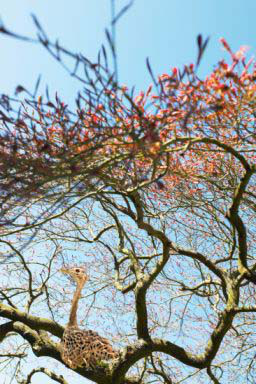

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((1024, 1024)),
    transforms.Normalize((0.5,), (0.5,))
])
img_path = 'figure/Sp_D_CRN_A_nat0093_art0037_0388.jpg'
img = Image.open(img_path)
img

In [36]:
with torch.no_grad():
    trans_img = transform(img).unsqueeze(0).to(device)
    msk = sam(trans_img)

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 64, 64]))

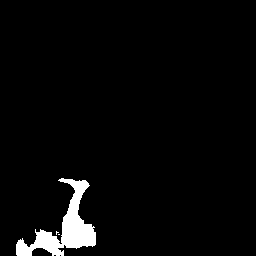

In [38]:
# tensor -> PIL
np_msk = (msk.squeeze(0) > 0) * 255
np_msk = np_msk.cpu().numpy().astype(np.uint8)
np_msk = np_msk.transpose(1, 2, 0)
np_msk = np_msk.squeeze(2)
np_msk = Image.fromarray(np_msk)
np_msk

In [39]:
# gt_path = img_path.replace('.jpg', '_mask.png').replace('images', 'masks')
# gt = Image.open(gt_path)
# gt